# Example workflow

Going over all the steps at the current state of development

- Read mesh
- segment materials
- voxelise mesh
- complete shape
- predict material index
- remesh voxel
- inpaint new mesh

## Mesh Import
We first import the mesh and normalize its position and scale
We can use both open3D or trimesh meshes. However, trimesh provides much faster and more reliable voxelisation.

In [4]:
import trimesh
import numpy as np
from PIL import Image
import generationtools as gnt


mesh_path = 'data/textured_chair/Chair_1.obj'
mesh = trimesh.load(mesh_path)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Normalisation
To create a normalized input, we scale the mesh so its largest axis is 1

>!TODO find a way to center the mesh around its completed center

In [2]:
scale = 1 / np.max(mesh.extents)
center = mesh.centroid
for3matx = np.hstack((np.identity(3) * scale, center.reshape((3,1)) ))
transformMtx = np.vstack((for3matx, [0,0,0,1]))
mesh.apply_transform(transformMtx)

<trimesh.Trimesh(vertices.shape=(1068, 3), faces.shape=(1614, 3))>

## Material Detection

Materials are detected using a segmentation model. While these are slow, they are excellent at segmenting the whole image at once.
We use the segment anything model SAM

In [6]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import cv2
import numpy as np
from matplotlib import pyplot as plt

sam = sam_model_registry["vit_b"](checkpoint="data/checkpoints/sam_vit_b_01ec64.pth")
mask_generator = SamAutomaticMaskGenerator(sam)

<PIL.Image.Image image mode=RGB size=4096x4096 at 0x2367BC65910>
(512, 512, 3)


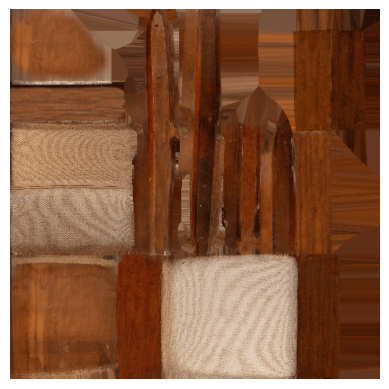

In [7]:
image = mesh.visual.material.image.convert('RGB')
print(image)
npImage = cv2.resize(np.array(image), (512,512))
print(npImage.shape)
plt.imshow(npImage)
plt.axis('off')
plt.show() 

### Generating the mask

In [23]:
masks = mask_generator.generate(npImage)

In [8]:
masks = np.load("data/textured_chair/masks.npy", allow_pickle = True)

Detected 40 patches


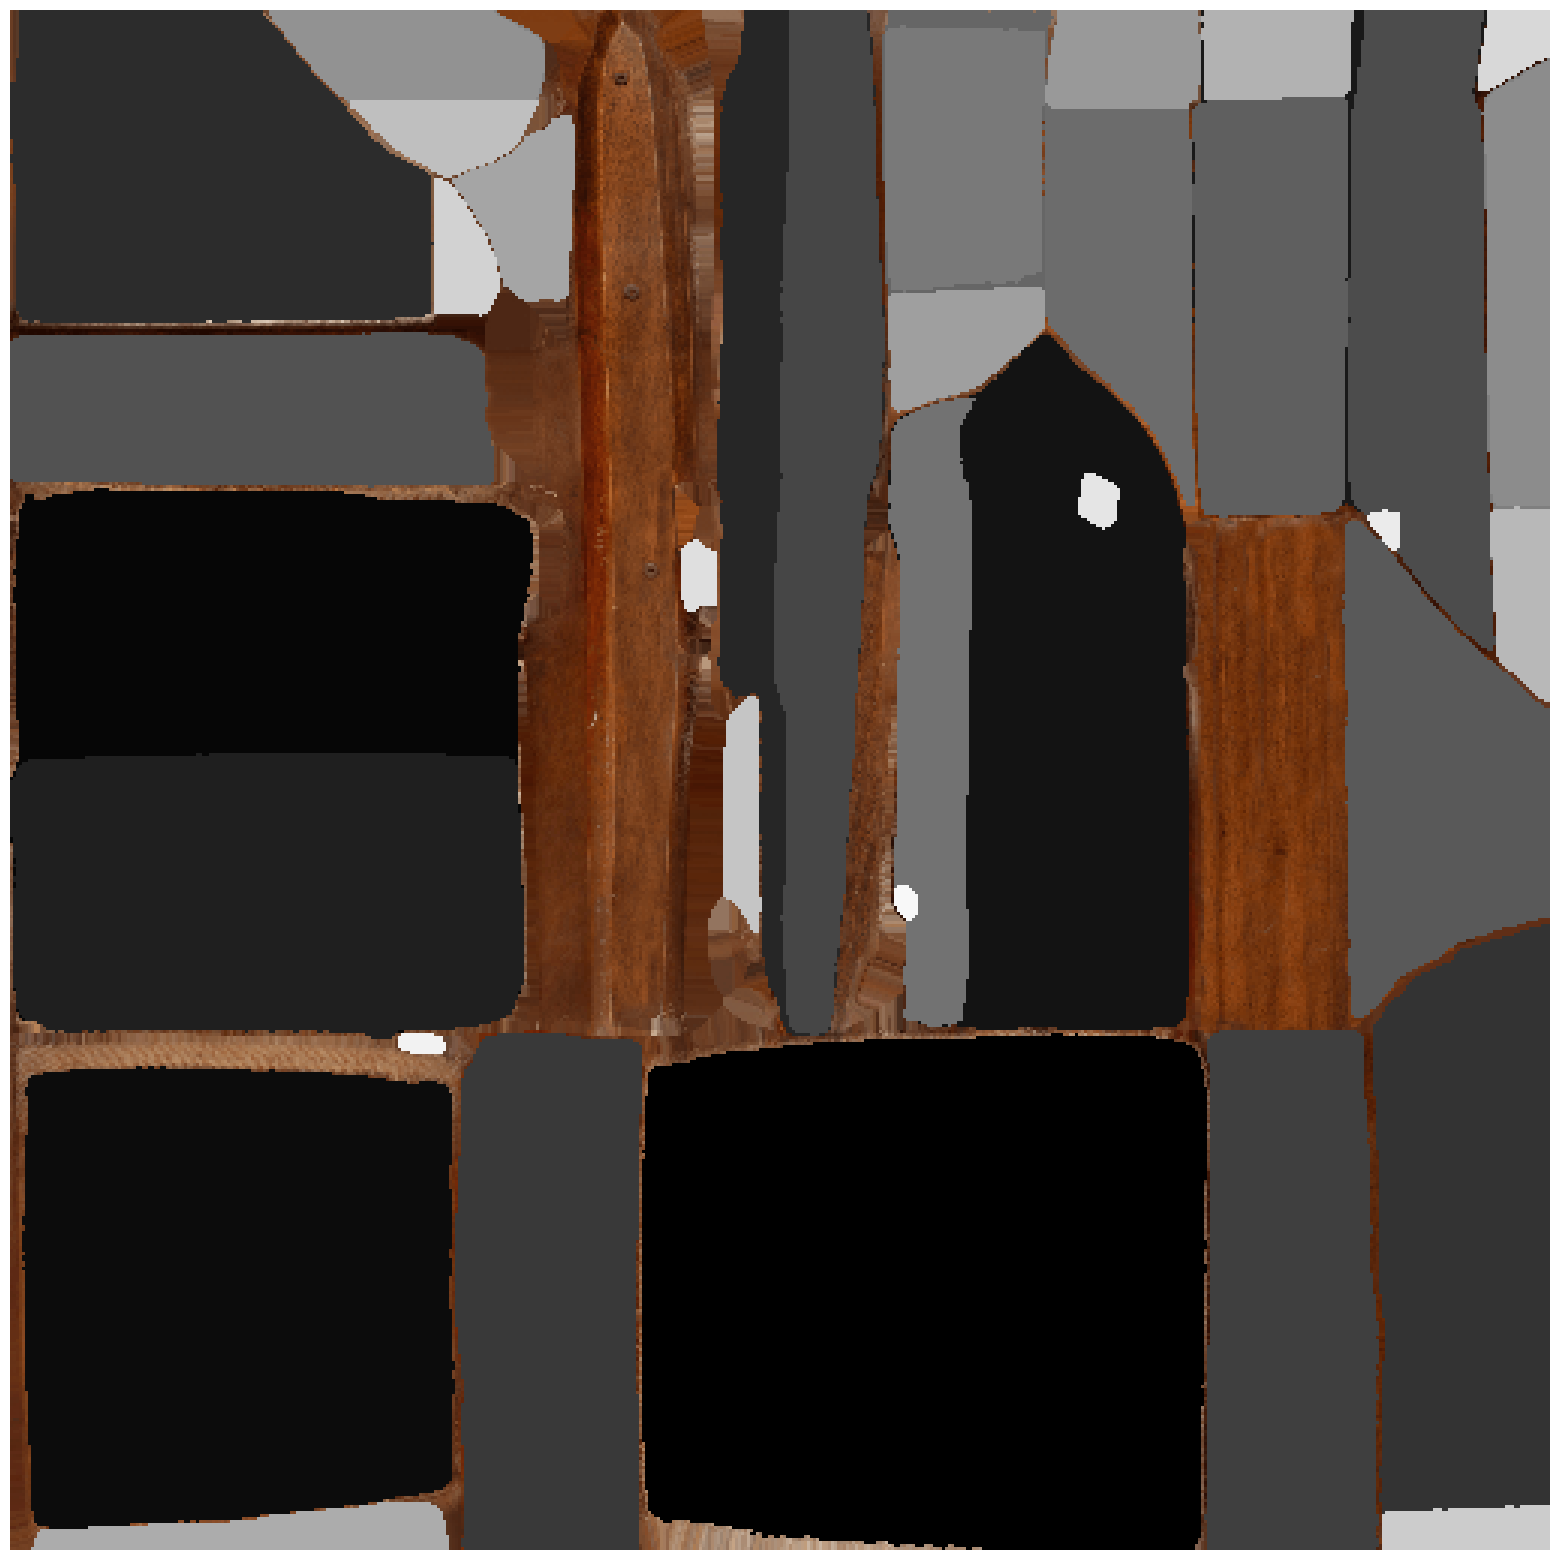

In [9]:
import generationtools as gnt
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(20,20))
plt.imshow(npImage)
gnt.show_mask_annotations(masks)
plt.axis('off')
plt.show() 

### Patch Similarity

All the patches in the image are detected separately, but this does not mean they are a different material. this is why we also perform a similarity detection over all the patches. For this we use efficient-net features as they can describe pattern very well, regardless of their scale or position.

In [10]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')
efficientnet.eval().to(device)
print("Model loaded")

Using cache found in C:\Users\u0146408/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\u0146408/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\u0146408/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in C:\Users\u0146408/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


Model loaded


### Comparing all Patches

Each patch is compared to each other patch and is given a similarity score based on the cosine similarity. This is all put in a comparison matrix.

In [13]:
from PIL import Image

nrOfPatches = len(masks)
isolatedImages = []
isolatedFeatures = []
originalImage = npImage

for mask in masks:
    isolatedImage = gnt.isolate_mask(originalImage,mask['segmentation'])
    isolatedImages.append(isolatedImage)
    imageTensor = gnt.load_jpeg_from_file(Image.fromarray(isolatedImage), isolatedImage.shape[0], False)
    isolatedFeatures.append(efficientnet(imageTensor))

compareMatrix = np.zeros([nrOfPatches, nrOfPatches])
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

for i in range(nrOfPatches):
    for j in range(i,nrOfPatches):
        compareMatrix[i,j] = cos(isolatedFeatures[i], isolatedFeatures[j])

print(compareMatrix)

[[1.         0.92846256 0.67653883 ... 0.57213241 0.54308128 0.53848851]
 [0.         1.         0.71189147 ... 0.67329943 0.65403491 0.64495301]
 [0.         0.         0.99999988 ... 0.57681638 0.50593144 0.50326133]
 ...
 [0.         0.         0.         ... 1.00000012 0.9779166  0.97498298]
 [0.         0.         0.         ... 0.         1.         0.99130982]
 [0.         0.         0.         ... 0.         0.         1.        ]]


### Defining groups based on threshold value

Groups are then created based the similarity score between all members

>! TODO find better grouping algorithm that doesn't just go from left to right

In [ ]:
threshold = 0.9

isGrouped = np.zeros(nrOfPatches)
groupIdxs = np.full(nrOfPatches,-1)
groupnr = 0
for i in range(nrOfPatches):
    #Check if it has already been grouped
    if(isGrouped[i] == 1): continue
    isGrouped[i] = 1
    groupIdxs[i] = groupnr
    groupnr +=1

    # only check half of the symmetrical matrix
    for j in range(i, nrOfPatches):
        # Check if the value is higher then the threshold
        if(compareMatrix[i,j] > threshold):
            groupIdxs[j] = groupIdxs[i]
            isGrouped[j] = 1

print(groupIdxs)

In [ ]:
def merge_images(images):
    newImage = np.zeros(images[0].shape, np.uint8)

    for img in images:
        ret, mask = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)
        newImage = cv2.bitwise_and(newImage, newImage, mask = cv2.bitwise_not(mask))
        newImage = cv2.add(newImage, img)
    return newImage


nrOfGroups = np.max(groupIdxs)

for i in range(nrOfGroups+1):
    group1Images = []
    print(i)

    for idx in range(len(groupIdxs)):
        if(groupIdxs[idx] == i):
            group1Images.append(isolatedImages[idx])


    group1Image = merge_images(group1Images)
    plt.imshow(cv2.cvtColor(group1Image,cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

### Segmented Texture

Once the groups are determined, they are stored as indexes in a new texture

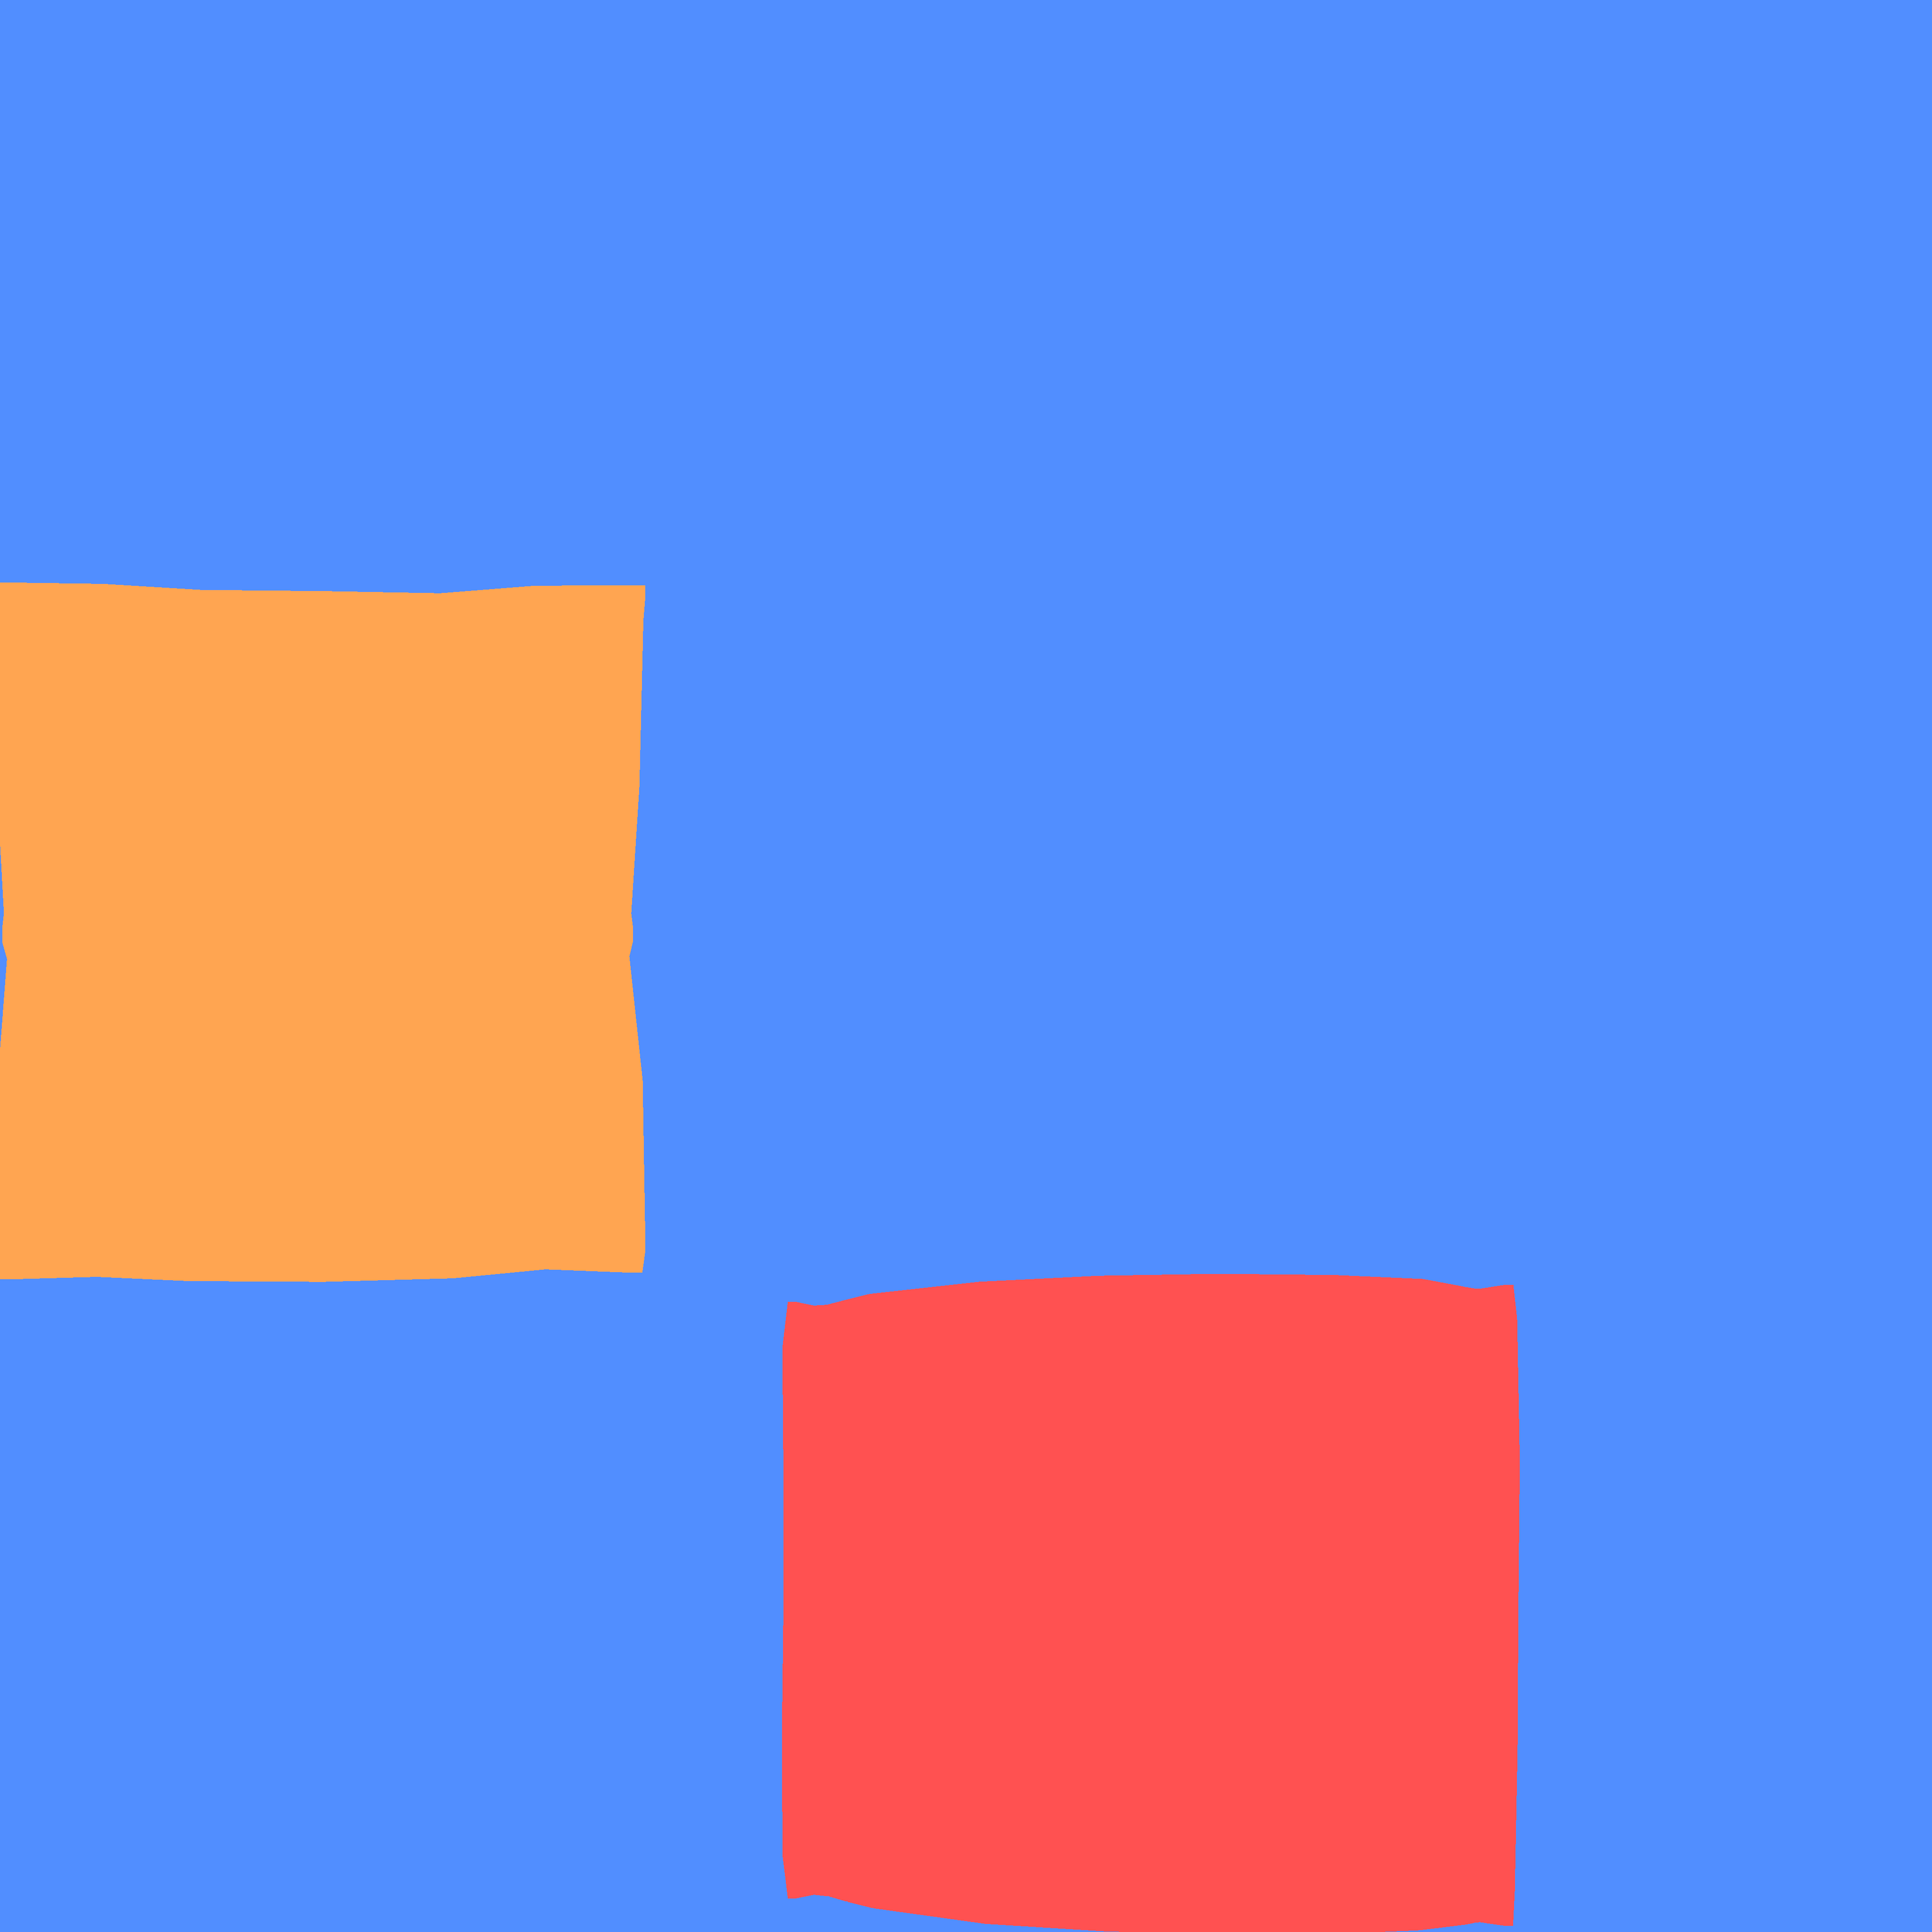

In [2]:
segTex = Image.open("data/textured_chair/materialcolor.png")
display(segTex)

### Apply texture to mesh

The texture is applied to the original mesh

In [3]:
mesh.visual.material.image = segTex
mesh.show(smooth=False)

## Mesh Voxelisation

The mesh can be voxelised with or without colors.

In [4]:
voxelMesh, colorGrid, voxelScale = gnt.mesh_to_voxelgrid_trimesh(mesh, 64, hollow = True)

In [5]:
voxelized_mesh = voxelMesh.as_boxes(colors=colorGrid)
scene = trimesh.Scene()
scene.add_geometry(voxelized_mesh)
scene.show()

### Voxel normalisation
Because the voxelised output does not automatically pad the space with extra voxels, we add more voxels around the smallest axis

In [13]:
print(voxelMesh.matrix.astype(int).shape)
zeros1 =  np.zeros((14, 64,41))
print(zeros1.shape)
zeros2 = np.zeros((64,64,64-41))

FilledVoxels = np.vstack((zeros1,np.vstack((voxelMesh.matrix.astype(int),zeros1))))
FilledVoxels2 = np.concatenate((FilledVoxels, zeros2), axis = 2)
print(FilledVoxels.shape)
print(FilledVoxels2.shape)




(36, 64, 41)
(14, 64, 41)
(64, 64, 41)
(64, 64, 64)


### Tensor conversion
The voxelgrids are converted to a tensor to send to the completion algorithm.

In [15]:
import torch
shapedData = np.reshape(FilledVoxels2, [1, 1, 64, 64, 64])
print(shapedData.shape)
torch.save(torch.from_numpy(shapedData).float(), "data/voxelChair.pt")

(1, 1, 64, 64, 64)


In [16]:
print(shapedData)

[[[[[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]

   [[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]

   [[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]

   ...

   [[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]

   [[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]

   [[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0.

## Voxel completion

The voxelgrid is send to Auto-SDF for geometry completion

In [ ]:
voxel_array = np.load("voxelarray.np")

## Voxel remeshing

once the object is completed, we convert it to a mesh again

In [1]:
!pip install PyMCubes

     ---------------------------------------- 44.0/44.0 KB ? eta 0:00:00


You should consider upgrading via the 'C:\Users\u0146408\Documents\DoctoraatLocal\generationtools\env\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
import skimage
import trimesh

vertices, faces, normals, _ = skimage.measure.marching_cubes(voxelMesh, level=0)
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)
mesh.show()

## UV Unwrapping

The new mesh need proper uvs in order inpaint the material

In [2]:
!pip install xatlas

     ------------------------------------- 191.1/191.1 KB 11.3 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\u0146408\Documents\DoctoraatLocal\generationtools\env\Scripts\python.exe -m pip install --upgrade pip' command.


In [5]:
mesh.unwrap()

<trimesh.Trimesh(vertices.shape=(1455, 3), faces.shape=(1614, 3))>

In [ ]:
# geometry based uv unwrapping

In [ ]:
for facet in mesh.facets:
    mesh.visual.face_colors[facet] = trimesh.visual.random_color()

# preview mesh in an opengl window if you installed pyglet and scipy with pip
mesh.show()

## Texture transfer

Before the texture can be completed the original partial texture needs to be transferred to the new mesh. This is necessary to ensure a proper link between the material index and the partial existing texture.

In [ ]:
# open the uv texture map of the new mesh

# for each pixel, find its 3D coordinate

# find the closest point from the pixel point onto the original partial mesh

# sample the pixel value of the closest point 

## Texture inpainting

The final part is painting the texture back where the existing meshtextures are re-baked onto the new mesh, and the material indexes are used as mask for reference

### Patch based Texture Inpainting
https://github.com/Analyzable-FR/patch-based-texture-inpainting

In [ ]:
!pip install patch-based-inpainting

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Define the images
baseImagePath = "data/textured_chair/HalfBakedTexture.png"
knownMaskMaterial1Path = "data/textured_chair/knownHalfUvMaterial1.png"
unknownMaskMaterial1Path = "data/textured_chair/unknownHalfUvMaterial1.png"
knownMaskMaterial2Path = "data/textured_chair/knownHalfUvMaterial2.png"
unknownMaskMaterial2Path = "data/textured_chair/unknownHalfUvMaterial2.png"
imageSize = (512,512)

# Preparing the examples
baseImage = cv2.resize(cv2.imread(baseImagePath),imageSize)

In [3]:
knownMask1 = cv2.resize(cv2.imread(knownMaskMaterial1Path,0),imageSize)
knownMask1[knownMask1>5] = 255 # Make sure the mask is pure white
knownMask1[knownMask1<5] = 0 # Make sure the mask is pure white
unknownMask1 = cv2.resize(cv2.imread(unknownMaskMaterial1Path,0),imageSize)
unknownMask1[unknownMask1>5] = 255 # Make sure the mask is pure white
unknownMask1[unknownMask1<5] = 0 # Make sure the mask is pure white

knownMask2 = cv2.resize(cv2.imread(knownMaskMaterial2Path,0),imageSize)
knownMask2[knownMask2>5] = 255 # Make sure the mask is pure white
knownMask2[knownMask2<5] = 0 # Make sure the mask is pure white
unknownMask2 = cv2.resize(cv2.imread(unknownMaskMaterial2Path,0),imageSize)
unknownMask2[unknownMask2>5] = 255 # Make sure the mask is pure white
unknownMask2[unknownMask2<5] = 0 # Make sure the mask is pure white

In [4]:
def show_images(maskedImg, fixedImg, gtImg, title = "Images"):
    plt.rcParams['figure.figsize'] = [15, 5]
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(maskedImg, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 3, 2)
    plt.title(title)
    plt.imshow(cv2.cvtColor(fixedImg, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(gtImg, cv2.COLOR_BGR2RGB))
    plt.show()

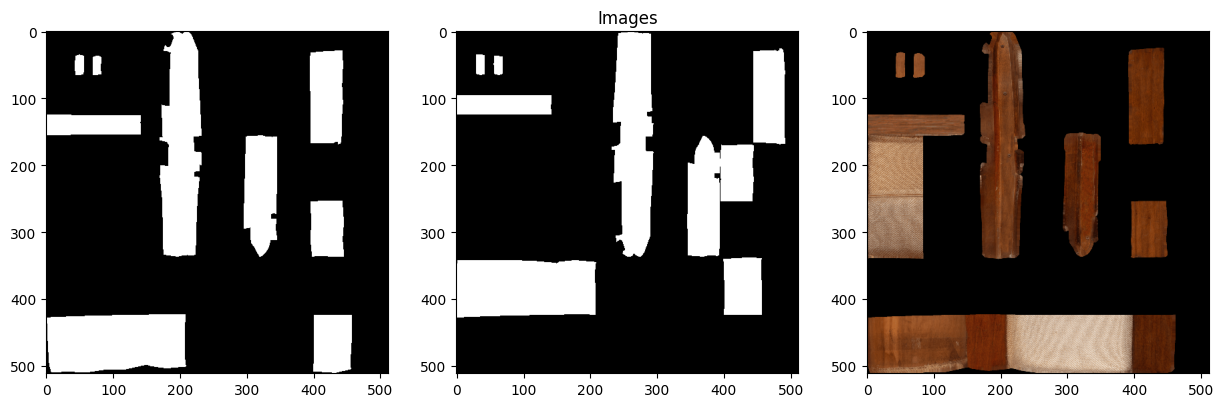

In [5]:
show_images(knownMask2, unknownMask2, baseImage)

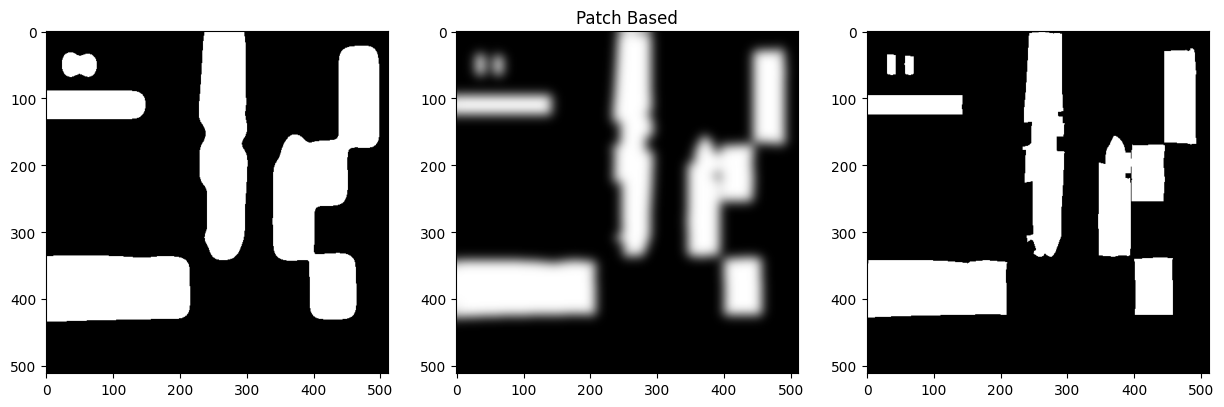

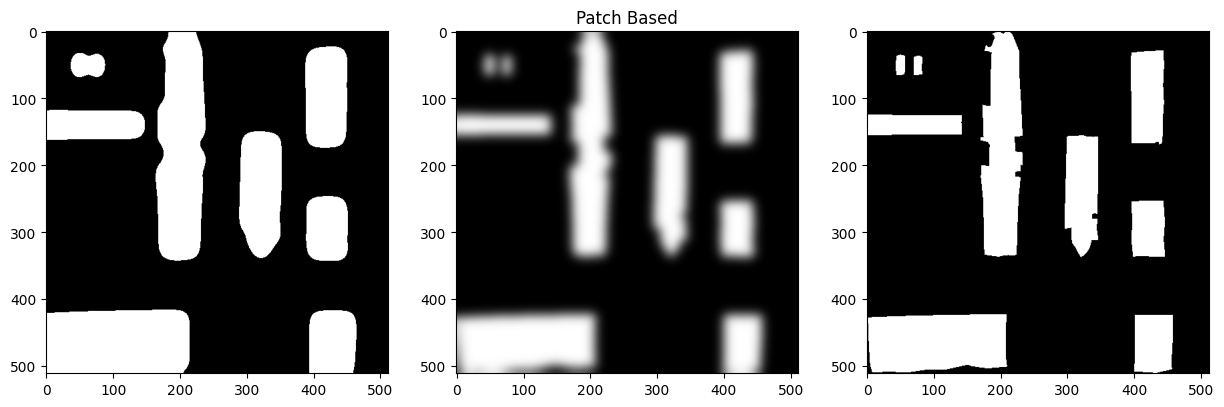

In [37]:
unknownMask2Blurred = cv2.GaussianBlur(unknownMask2, (51, 51), 0)
(T, unknownMask2Tres) = cv2.threshold(unknownMask2Blurred, 50, 255,cv2.THRESH_BINARY)
show_images(unknownMask2Tres, unknownMask2Blurred, unknownMask2, "Patch Based")

knownMask2Blurred = cv2.GaussianBlur(knownMask2, (51, 51), 0)
(T, knownMask2Tres) = cv2.threshold(knownMask2Blurred, 50, 255,cv2.THRESH_BINARY)
show_images(knownMask2Tres, knownMask2Blurred, knownMask2, "Patch Based")

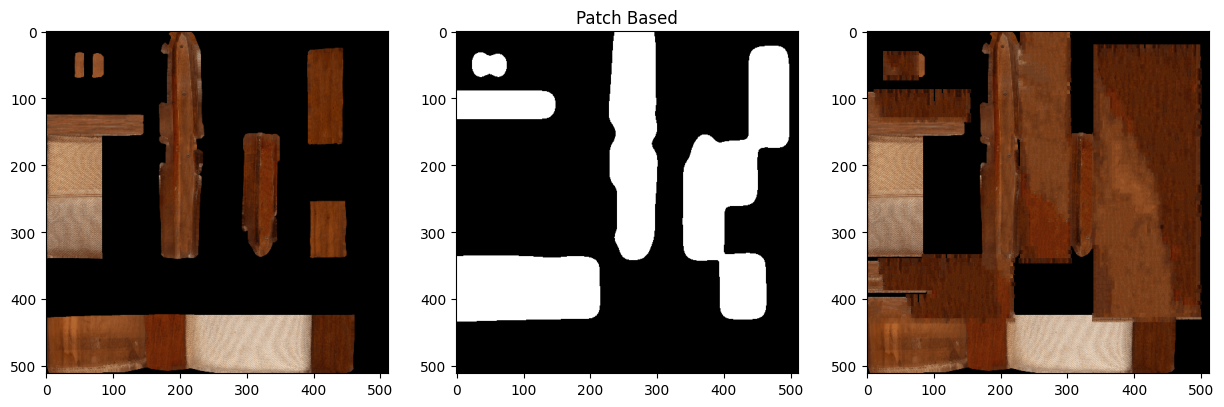

In [43]:
# unconditional inpainting 
import patch_based_inpainting
import cv2

patch_size = 4
overlap_size = 2
rotation = [0,45,90,135,180]

patcher2 = patch_based_inpainting.inpaint.Inpaint(baseImage, unknownMask2Tres, patch_size, overlap_size, training_area=knownMask2Tres, window_step=None, mirror_hor=True, mirror_vert=True, rotation=None, method='gaussian')
fixed2Image = patcher2.resolve()
show_images(baseImage, unknownMask2Tres, fixed2Image, "Patch Based")

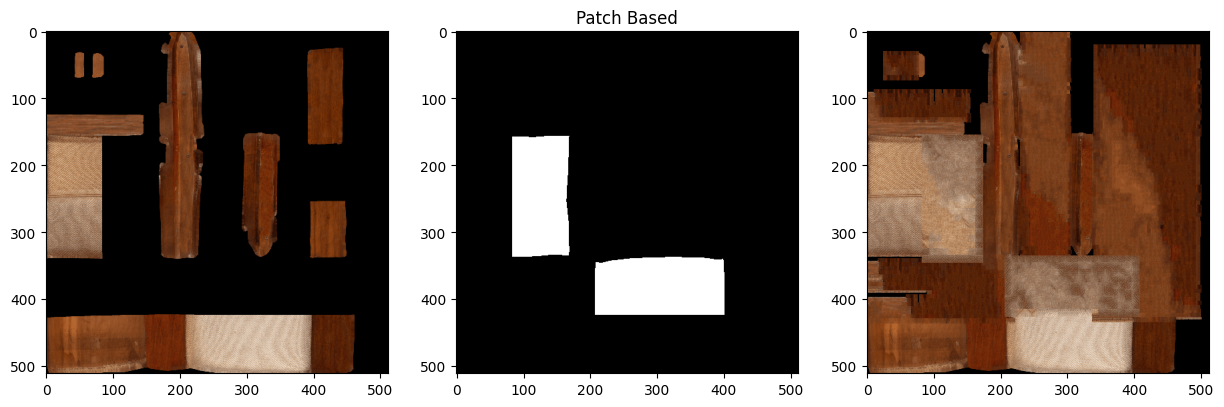

In [44]:


patch_size = 8
overlap_size = 2
rotation = [0,45,90,135,180]

patcher = patch_based_inpainting.inpaint.Inpaint(fixed2Image, unknownMask1, patch_size, overlap_size, training_area=knownMask1, window_step=None, mirror_hor=True, mirror_vert=True, rotation=rotation, method='gaussian')
fixed1Image = patcher.resolve()
show_images(baseImage, unknownMask1, fixed1Image, "Patch Based")

In [45]:
cv2.imwrite("data/inpaintedTextureChair.png", fixed1Image)

True